In [30]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sn
plot_params = {'color': '0.75',
                'style': '.-',
                'markeredgecolor': '0.25',
                'markerfacecolor': '0.25',
                'legend': False}
sn.set_style("dark")
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import Holt

In [110]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y , y_pred))
def mae(y, y_pred):
    return mean_absolute_error(y, y_pred)
def mape(y, y_pred):
    return (np.abs(y - y_pred) / y).mean() * 100
def evaluate(y, y_pred):
    print("MAE:", mae(y, y_pred))
    #print("MSE:", mse(y, y_pred))
    print("RMSE:", rmse(y, y_pred))
    print("MAPE:", mape(y, y_pred))

# Advanced Smoothing Double exp

This method works with **stationary and trend** time series. If we want to use this method, the time series should **have not a seasonality**.

This method:

- Can handle level and trend
- Exponentially correcting by considering the trend effect
- In addition to SES, the trend is also taken into account
- Should be used on the time series that have no seasonality and have single variable (feature)
The formula:
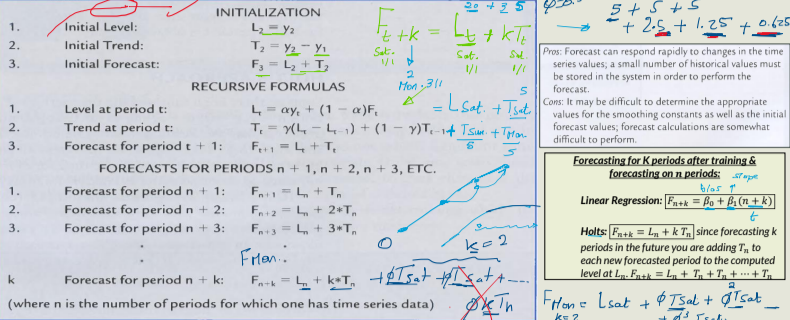
Double Exponential Smoothing with an additive trend is classically referred to as

Holt’s linear trend model, named for the developer of the method Charles Holt.

- Additive Trend: Double Exponential Smoothing with a linear trend.
- Multiplicative Trend: Double Exponential Smoothing with an exponential trend.
- !!! For longer range (multi-step) forecasts, the trend may continue unrealistically. As
such, it can be useful to **dampen the trend over time**.
- **Dampening** means reducing the size of the trend over future time steps down to a
straight line (no trend). (the lower the 𝜙 the higher the degree of dampening).
- As with modeling the trend itself, we can use the same principles in dampening the
trend, specifically additively or multiplicatively for a linear or exponential
dampening effect. A damping coefficient φ is used to control the rate of dampening.

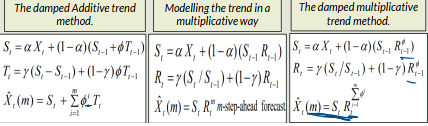

In [84]:
data = pd.read_csv("AirPassengers.csv")
data.set_index('Month', inplace=True)

<AxesSubplot:xlabel='Month'>

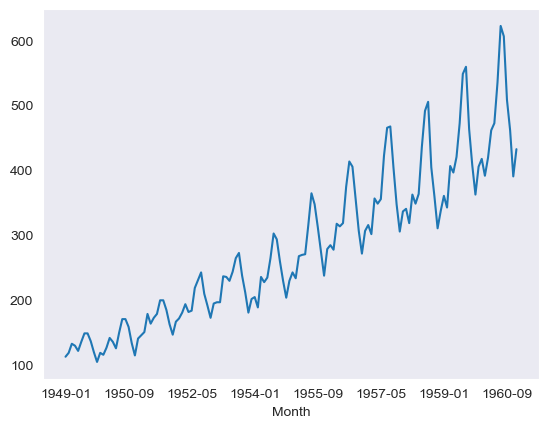

In [85]:
data['#Passengers'].plot()

In [86]:
ts_data = data["#Passengers"]
train = ts_data [:133]
test =  ts_data[133:]

## linear  TREND || optimized 
double_linear = Holt(train).fit(optimized=True)
double_preds_linear = double_linear.forecast(len(test))

## exp TREND || optimized 
double_exp = Holt(train,exponential=True).fit(optimized=True)
double_preds_exp = double_exp.forecast(len(test))
#  damped trend ||additive || optimized 
double_damp = Holt(train,damped_trend=True).fit(optimized=True)
double_preds_damp = double_damp.forecast(len(test))
# damped and exp trend ||multiplicative  || optimized 
double_exp_dam = Holt(train,exponential=True, damped_trend=True).fit(optimized=True)
double_preds_exp_dam = double_exp_dam.forecast(len(test))



## CALCULATE MEAN SQUARE ERROR FOR each MODEL 
mse_linear = mean_squared_error(test,double_preds_linear)
mse_exp = mean_squared_error(test,double_preds_exp)
mse_damp = mean_squared_error(test,double_preds_damp)
mse_damp_exp = mean_squared_error(test,double_preds_exp_dam)


params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "initial_level",
    "initial_trend",
]
results = pd.DataFrame(
    index=["smoothing_level", "smoothing_trend", "damping_trend", "initial_level", "initial_trend", "MSE"],
    columns=[ "linear", "Exponential", "Additive", "Multiplicative"],
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "initial_level",
    "initial_trend",
]
results = pd.DataFrame(
    index=["smoothing_level", "smoothing_trend", "damping_trend", "initial_level", "initial_trend", "MSE"],
    columns=[ "linear", "Exponential", "Additive", "Multiplicative"],
)
results["linear"] = [double_exp.params[p] for p in params] + [mse_linear]
results["Exponential"] = [double_exp.params[p] for p in params] + [mse_exp]
results["Additive"] = [double_damp.params[p] for p in params] + [mse_damp]
results["Multiplicative"] = [double_exp_dam.params[p] for p in params] + [mse_damp_exp]
results


,linear,Exponential,Additive,Multiplicative
smoothing_level,0.992138,0.992138,0.99500,0.995053
smoothing_trend,0.034045,0.034045,0.00010,0.010687
damping_trend,NaN,NaN,0.99000,0.987978
initial_level,112.063749,112.063749,112.00000,111.868816
initial_trend,1.032325,1.032325,6.00000,1.054518
MSE,8169.156602,6828.787878,8734.70257,7569.685205


From the mse values it's obvious that exp trend model has the least mse

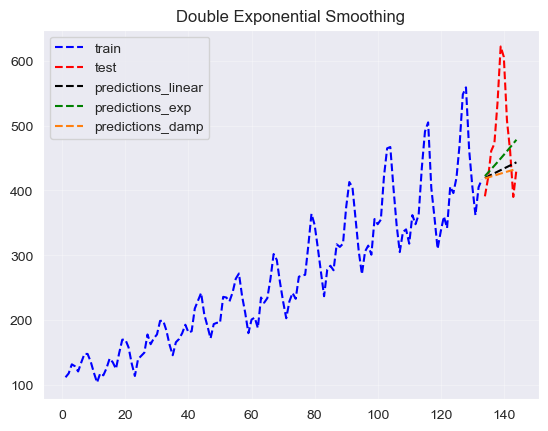

In [87]:
data = pd.read_csv("AirPassengers.csv")
time = np.arange(1 , len(data["Month"])+1)
plt.plot(time[:-11], train, 'b--', label="train")
plt.plot(time[-11:], test, 'r--', label="test")
plt.plot(time[-11:], double_preds_linear, "k--", label="predictions_linear")
plt.plot(time[-11:], double_preds_exp, "g--", label="predictions_exp")
plt.plot(time[-11:], double_preds_damp, "C1--" , label="predictions_damp")


plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

In [88]:
evaluate(test.values,double_preds_exp.values)

MAE: 63.436805201527406
RMSE: 82.63648030965757
MAPE: 12.29899850103386


Evalution using Rolling Forward for evalution next day

In [89]:
data = pd.read_csv("AirPassengers.csv")
data.set_index('Month', inplace=True)
train_window = 24  # Number of past periods to use for training
test_window = 1   # Number of future periods to use for testing

# Define lists to store actual and predicted values
y_true = []
y_pred = []

# Loop over the data and use rolling evaluation
for i in range(train_window, len(data)-test_window+1):
    # Split data into training and testing sets
    train_data = data.iloc[i-train_window:i]
    test_data = data.iloc[i:i+test_window]
    
    # Fit SES model to training data
    double_exp = Holt(train_data,exponential=True).fit(optimized=True)
    
    # Make predictions for testing data
    predictions = double_exp.forecast(test_window)
    
    # Append actual and predicted values to lists
    y_true.append(test_data.values)
    y_pred.append(predictions)

In [120]:
evaluate(np.concatenate(y_true).reshape(len(y_true)), np.concatenate(y_pred))

MAE: 31.46000458289336
RMSE: 39.93998825723024
MAPE: 9.709594814620624


The double exp still can't catch the trend but cannot catch the seasonality